In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import nengo
import numpy as np

class Delay(nengo.synapses.Synapse):
    def __init__(self, delay, size_in=1):
        self.delay = delay
        super().__init__(default_size_in=size_in, default_size_out=size_in)

    def make_state(self, shape_in, shape_out, dt, dtype=None, y0=None):
        return {}

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        steps = int(self.delay/dt)
        print('steps', steps)
        if steps == 0:
            def step_delay(t, x):
                return x
            return step_delay
        assert steps > 0

        state = np.zeros((steps, shape_in[0]))
        state_index = np.array([0])

        def step_delay(t, x, state=state, state_index=state_index):
            result = state[state_index]
            state[state_index] = x
            state_index[:] = (state_index + 1) % state.shape[0]
            return result

        return step_delay

In [135]:
import nengo_spa as spa
import nengo
import gym
import logging
gym.logger.set_level(logging.ERROR)  # suppress the error of running the model after it's done
import numpy as np
import pytry

class CartPoleTrial(pytry.PlotTrial):
    def params(self):
        self.param('time to run', T=10)
        self.param('gate error signal', gate_error=False)
        self.param('gate future value signal', gate_future_value=False)
        self.param('RL discount rate', gamma=0.9)
        self.param('use SSP representation', use_ssp=False)
        self.param('number of neurons', n_neurons=1000)
        self.param('learning rate', learning_rate=1e-4)
        self.param('learning rate for actor', learning_rate_actor=1e-4)
        self.param('SSP scale', ssp_scale=1)
        self.param('normalize state', normalize_state=False)
        self.param('sample encoders from represented space', sample_encoders=False)
        self.param('multiplicative SSP', ssp_multiply=False)
        self.param('cosine intercepts', cosine_intercepts=False)
        self.param('done time', done_time=20)
        self.param('reset time', reset_time=20)
        
        
    def evaluate(self, p, plt):
        # define the OpenAI gym environment interface
        class CartPole:
            def __init__(self, done_time=p.done_time, reset_time=p.reset_time, seed=None):
                self.env = gym.make('CartPole-v0')
                self.env.seed(seed)
                self.env.reset()
                self.reset_time = reset_time
                self.done_time = done_time
                self.reset_counter = 0
                self.rng = np.random.RandomState(seed=seed)
                if p.normalize_state:
                    self.state_scale = 1.0/np.array([0.22055888, 0.70636221, 0.44982735, 1.8954963])
                else:
                    self.state_scale = np.ones(4)
                    
            def update(self, t, x):
                is_done = 0 < self.reset_counter <= self.done_time
                if self.reset_counter > 0:
                    reward = 1
                    if self.reset_counter > self.reset_time:
                        self.env.step(self.env.action_space.sample())
                        reward = 0
                    if self.reset_counter == self.reset_time:
                        self.env.reset()
                    self.reset_counter -= 1
                else:
                    action = 0 if x[0]==1 else 1
                    obs, reward, done, info = self.env.step(action)
                    if done:
                        self.reset_counter = self.reset_time + self.done_time
                return np.hstack([self.env.state*self.state_scale, [reward, is_done]])
        
        # choose the style of representation to use
        if p.use_ssp:
            D = 128
            vocab = spa.Vocabulary(D)
            X = vocab.create_pointer().unitary().v
            DX = vocab.create_pointer().unitary().v
            A = vocab.create_pointer().unitary().v
            DA = vocab.create_pointer().unitary().v
            
            def power(s, e):
                return np.fft.ifft(np.fft.fft(s) ** e).real
            def circ_conv(a, b):
                return np.fft.ifft(np.fft.fft(a) * np.fft.fft(b)).real
            
            

            if p.ssp_multiply:
                def convert(x):
                    return circ_conv(circ_conv(power(X, x[0]*p.ssp_scale),power(DX, x[1])) , circ_conv(power(A, x[2]*p.ssp_scale),power(DA, x[3])))
            else:
                def convert(x):
                    return power(X, x[0]*p.ssp_scale) + power(DX, x[1]) + power(A, x[2]*p.ssp_scale) + power(DA, x[3])
        else:
            def convert(x):
                return x
            

        # define the nengo model
        env = CartPole(seed=p.seed)
        model = nengo.Network()
        with model:
            cp = nengo.Node(env.update, size_in=2, size_out=6)
            p_env = nengo.Probe(cp)

                
            ens = nengo.Ensemble(n_neurons=p.n_neurons, 
                                 dimensions=D if p.use_ssp else 4,
                                 radius=1 if p.use_ssp else 2,
                                 neuron_type=nengo.RectifiedLinear())
            
            if p.use_ssp and p.sample_encoders:
                encoders = []
                for i in range(ens.n_neurons):
                    x = np.random.uniform(-1, 1, size=4)
                    e = convert([x[0]*2, x[1]*2, x[2]*2, x[3]*2])
                    encoders.append(e)
                ens.encoders = np.array(encoders)
                
              
            if p.cosine_intercepts:
                ens.intercepts = nengo.dists.CosineSimilarity(ens.dimensions+2)
            nengo.Connection(cp[:4], ens, function=convert, synapse=None)
                
            v = nengo.Node(None, size_in=1)
            c = nengo.Connection(ens.neurons, v, transform=np.zeros((1, ens.n_neurons)), 
                                 learning_rule_type=nengo.PES(learning_rate=p.learning_rate, pre_synapse=0),
                                 synapse=None)


            error = nengo.Node(None, size_in=1)
            nengo.Connection(cp[4], error, transform=-1, synapse=0)
            nengo.Connection(v, error, transform=1, synapse=0)

            if p.gate_future_value:
                gated_value = nengo.Node(lambda t, x: x[0] if (x[1]==0) else 0, size_in=2, size_out=1)
                nengo.Connection(v, gated_value[0], synapse=None)
                nengo.Connection(cp[5], gated_value[1], synapse=None)
                nengo.Connection(gated_value, error, transform=-p.gamma, synapse=None)
            else:
                nengo.Connection(v, error, transform=-p.gamma, synapse=None)

            if p.gate_error:
                gate = nengo.Node(lambda t, x: x[0] if (x[1]==0) else 0, size_in=2, size_out=1)
                nengo.Connection(error, gate[0], synapse=None)
                nengo.Connection(cp[5], gate[1], synapse=None)
                nengo.Connection(gate, c.learning_rule, transform=1, synapse=None)
            else:
                nengo.Connection(error, c.learning_rule, transform=1, synapse=None)

            p_v = nengo.Probe(v)
            
            tau_fast = None
            tau_slow = 0
            # the raw output from the network
            raw_actions = nengo.Node(None, size_in=2, label='raw_actions')

            # compute the softmax
            def softmax(t, x):
                scale = 1
                return np.exp(x*scale)/np.sum(np.exp(x*scale))
            actions = nengo.Node(softmax, size_in=2, label='actions')
            nengo.Connection(raw_actions, actions, synapse=None)

            # do the random sampling and output which action we're taking
            #  (here I just decided to represent choosing the action as +1 and not choosing as -1)
            def choice_func(t, x):
                c = np.random.choice(np.arange(2), p=x)
                result = [-1, -1]
                result[c] = 1
                return result
            choice = nengo.Node(choice_func, size_in=2, size_out=2, label='choice')
            nengo.Connection(actions, choice, synapse=None)

            # and now connect the choice to the environment
            nengo.Connection(choice, cp, synapse=0)

            # and here is the computation of the error signal
            c_actor = nengo.Connection(ens.neurons, raw_actions, transform=np.zeros((2, ens.n_neurons)), 
                                       learning_rule_type=nengo.PES(learning_rate=p.learning_rate_actor, pre_synapse=Delay(0.02)),
                                       synapse=None)

            # implement the advantage actor-critic error rule
            #  the Node gets 5 inputs: the delta for the critic part, 2 values indicating which action was chosen
            #  (+1 for the chosen and -1 for the non-chosen ones), and the choice probabilities for the 2 actions
            def actor_error_func(t, x):
                delta = x[0]
                chosen = x[1:3]
                prob = x[3:5]
                # compute the error
                #e = np.where(chosen>0, delta*(1-prob), -delta*prob)
                e = np.where(chosen>0, delta, -delta)
                return e

            actor_error = nengo.Node(actor_error_func, size_in=5, label='actor_error')
            nengo.Connection(error, actor_error[0], synapse=None)
            nengo.Connection(choice, actor_error[1:3], synapse=None)
            nengo.Connection(actions, actor_error[3:5], synapse=None)
            nengo.Connection(actor_error, c_actor.learning_rule, transform=-1, synapse=None) 
            
            p_raw_actions = nengo.Probe(raw_actions)
            p_prob = nengo.Probe(actions)

            
            
            

        # run the model
        sim = nengo.Simulator(model, dt=0.01)
        sim.run(p.T)
        
        # make the summary plot, if asked
        if plt:
            v = sim.data[p_v]
            x = np.arange(40)-20

            reward = sim.data[p_env][:,4]
            align = np.where(np.diff(reward) == -1)[0]
            groups = np.linspace(0, len(v), 5).astype(int)

            plt.figure(figsize=(14,3))
            for index in range(4):
                total = []
                ax = plt.subplot(1, 4, index+1, sharey=ax if index>0 else None)
                for i in align:
                    if groups[index]<i<groups[index+1]:
                        vv = v[i-20:i+20,0].copy()
                        if len(vv)!=40:
                            continue
                        rr = reward[i-20:i+10]
                        vv[:20][rr[:20]<1] = np.nan
                        plt.plot(x, vv, alpha=0.2)
                        total.append(vv)
                plt.plot(x, np.nanmean(total, axis=0), c='k', lw=3, label='mean')

                plt.legend()
                plt.axvline(0)
                plt.title('steps %d-%d\n(N=%d)' % (groups[index], groups[index+1], len(total)))
            plt.tight_layout()
            ylim = plt.ylim()
            plt.ylim(0, ylim[1])
            
        # return the raw environment data and the decoded value
        return dict(v=sim.data[p_v], env=sim.data[p_env], 
                    raw_actions=sim.data[p_raw_actions], prob=sim.data[p_prob])

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

steps 2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

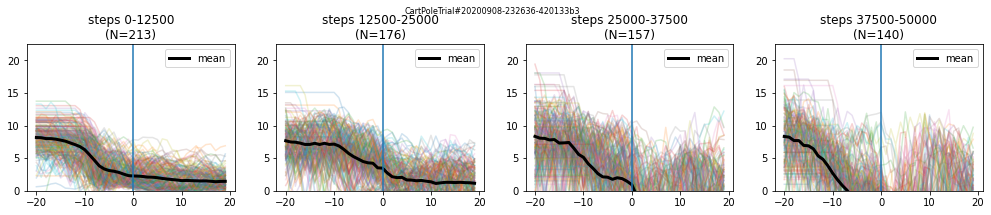

In [192]:
r = CartPoleTrial().run(data_dir=None, verbose=False, T=500, plt=True, use_ssp=True, ssp_scale=20, 
                        learning_rate=1e-4, learning_rate_actor=1e-4, sample_encoders=True, gate_error=True, gate_future_value=False,
                        cosine_intercepts=True, done_time=20, reset_time=20)

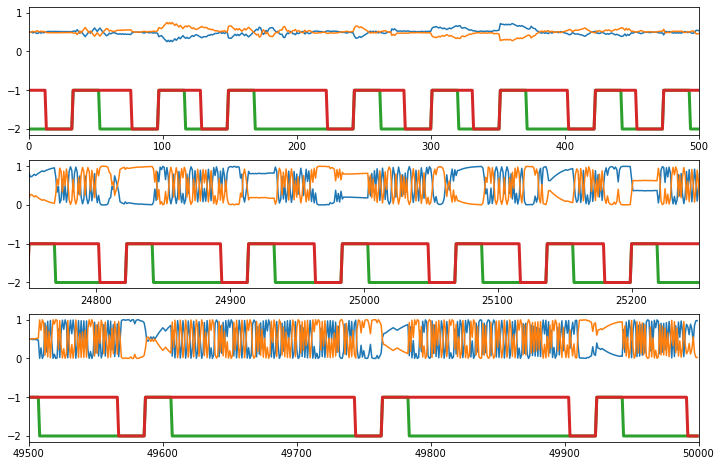

In [193]:
plt.figure(figsize=(12,8))

w = 500
pts = np.linspace(0, len(r['prob'])-w, 3).astype(int)

for i in range(len(pts)):
    plt.subplot(3, 1, i+1)
    plt.plot(r['prob'])
    plt.plot(r['env'][:,5]-2, label='reset', lw=3)
    plt.plot(r['env'][:,4]-2, label='reward', lw=3)
    plt.xlim(pts[i], pts[i]+500)


[ 24  12  54  18  11  31  11  14  31  13  29  13  13  14   9  12  14  12
  18  11  20  50  20  14  10  10  10  11  10   9  16  10  11  24   9   9
  14  20  19  12  14  18  12  10  11  15  11  12  27  21  49  15  12  17
  19  11  11  16  19  10  16  15  27  13  14  11  15  28  10  18  13  11
  17  21  20  26  25  13  19  29  13  13  19  20  17  11  10  13  11  13
  13  10  13  11  17  16  18  15  46  24  31  13  10   9  10  11  11  11
  10  12  11  19  33  37  11  11  12  19  17  41  17  18  19  10  16  16
  12  16  33  17  24  11  16  12  19  18  13  13  24  16  27  24  13   9
  10   9  11  10  11  13  11  14  14  18  20  50  26  12  56  12  13  15
  13  12  11  14  12  10  12  20  15  21  68  20  15  16  13  24  17  41
  45  52  14  12  12  10  12  13  14  11  12  14  16  11  14  14  17  30
  25  21  29  27  28  17  33  48  22  18  72  19  47  43  49  10  10   9
  11  11  10  12  11  11   9   8  11  10  12   9  13  12  11  12  12  11
  10  10  12  11  11  11  11  12  12  11  13  14  1

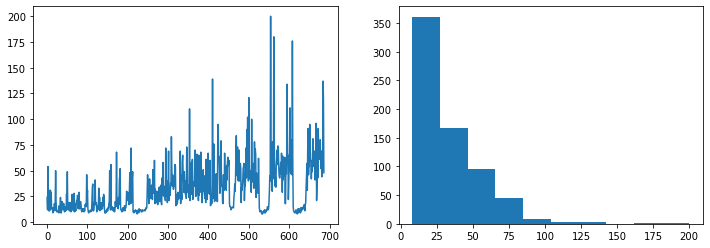

In [194]:
idx_start = np.where(np.diff(r['env'][:,5])==-1)[0]
idx_end = np.where(np.diff(r['env'][:,4])==-1)[0][1:]
idx_start = idx_start[:len(idx_end)]

print(idx_end - idx_start)
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(idx_end - idx_start)
plt.subplot(1, 2, 2)
plt.hist(idx_end - idx_start)
plt.show()

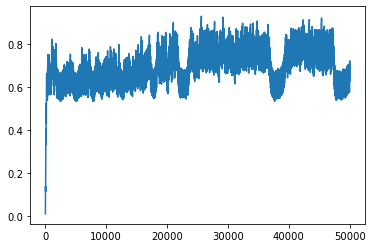

In [190]:




plt.plot(nengo.synapses.Lowpass(0.1).filt(r['env'][:,4]))

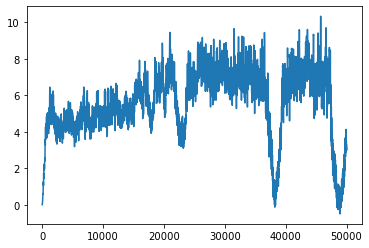

In [191]:
plt.plot(nengo.synapses.Lowpass(0.1).filt(r['v']))